IMPORTING LIBRARIES

In [1]:

import keras
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.core import SpatialDropout2D

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input,Flatten,UpSampling2D,Reshape, GlobalAveragePooling2D,Dense,MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
%matplotlib inline
!pip3 install -U segmentation-models

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install augmentor
import Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import logging



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


AUGMENTATION OF IMAGES

In [ ]:
class_1='Ascending Stairs'
root="/content/drive/MyDrive/Colab Notebooks/Staircase Dataset"
class_2='Descending Stairs'


In [ ]:
# Passing the path of the image directory
path=os.path.join(root,class_1)

p = Augmentor.Pipeline(source_directory=path,
                      output_directory="/content/drive/MyDrive/Colab Notebooks/Staircase Dataset/Asc_Aug")

# Defining augmentation parameters and generating 10 samples
p.flip_left_right(probability=0.4)
#p.flip_top_bottom(probability=0.8)
p.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=10)
p.skew(0.4, 0.5)
p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5)
p.sample(500)

Initialised with 50 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Staircase Dataset/Asc_Aug.

Processing <PIL.Image.Image image mode=RGB size=280x430 at 0x7F0B0F053FA0>: 100%|██████████| 500/500 [00:16<00:00, 30.15 Samples/s]


In [ ]:
# Passing the path of the image directory
path=os.path.join(root,class_2)

p = Augmentor.Pipeline(source_directory=path,
                      output_directory="/content/drive/MyDrive/Colab Notebooks/Staircase Dataset/Desc_Aug")

# Defining augmentation parameters and generating 10 samples
p.flip_left_right(probability=0.4)
#p.flip_top_bottom(probability=0.8)
p.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=10)
p.skew(0.4, 0.5)
p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5)
p.sample(500)

Initialised with 50 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Staircase Dataset/Desc_Aug.

Processing <PIL.Image.Image image mode=RGB size=280x430 at 0x7F0BB153BC70>: 100%|██████████| 500/500 [00:19<00:00, 25.55 Samples/s]


READING IMAGES AND CREATING DATASET

In [4]:
import random
def load_data(dir,uniqueLabels, size):
    img_array = []
    labels = []
    for category in uniqueLabels:
      path=os.path.join(dir,uniqueLabels)
      for img in random.sample(os.listdir(path),500):
          image=cv2.imread(os.path.join(path,img))
          resized_arr =  cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
          resized_arr =  cv2.resize(resized_arr,(size,size))
          img_array.append(resized_arr)
          labels.append(uniqueLabels)
    img_array = np.array(img_array)
    len(img_array)
    labels = np.array(labels)
    return(img_array, labels)

    #size = 32,32

In [5]:
class_1='Asc_Aug'
root="/content/drive/MyDrive/Colab Notebooks/Staircase Dataset"
class_2='Desc_Aug'


In [6]:
asc_Images,asc_label=load_data(root,class_1,100)
desc_Images,desc_label=load_data(root,class_2,100)

In [ ]:
asc_Images.shape

(3500, 100, 100, 3)

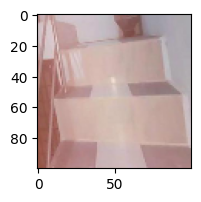

In [ ]:
plt.figure(figsize=(2, 2))

plt.imshow(asc_Images[90])

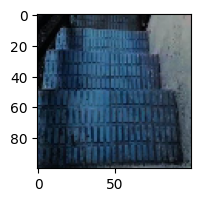

In [7]:
plt.figure(figsize=(2, 2))
plt.imshow(desc_Images[10])


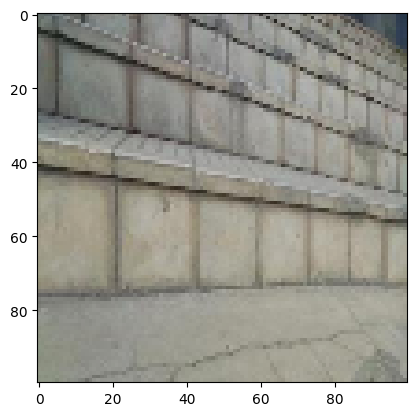

In [8]:
raw_x =[]

for feature in asc_Images:

     plt.imshow(feature)
     raw_x.append(feature)
for feature in desc_Images:
     raw_x.append(feature)




In [ ]:
raw_x=np.array(raw_x)
raw_x.ndim

4

In [ ]:
raw_x.shape

In [9]:
raw_y=[]
for label in asc_label:
  raw_y.append(label)
for label in desc_label:
  raw_y.append(label)

In [10]:
Stair_Images=np.array(raw_x)
Stair_label=np.array(raw_y)
Stair_Images


array([[[[202, 203, 205],
         [205, 206, 207],
         [200, 201, 203],
         ...,
         [166, 165, 170],
         [163, 162, 167],
         [167, 166, 172]],

        [[206, 207, 209],
         [206, 207, 209],
         [198, 199, 201],
         ...,
         [163, 162, 167],
         [166, 165, 170],
         [168, 167, 173]],

        [[209, 210, 212],
         [203, 204, 206],
         [198, 199, 201],
         ...,
         [159, 158, 163],
         [158, 157, 162],
         [156, 155, 161]],

        ...,

        [[161, 157, 146],
         [160, 156, 145],
         [165, 161, 150],
         ...,
         [117, 109,  98],
         [119, 111, 100],
         [120, 112, 101]],

        [[161, 157, 148],
         [165, 161, 152],
         [163, 159, 150],
         ...,
         [119, 111, 100],
         [117, 109,  98],
         [118, 110,  99]],

        [[178, 173, 167],
         [166, 161, 156],
         [164, 159, 153],
         ...,
         [111, 103,  92],
        

In [ ]:
print(Stair_Images.ndim)
print(Stair_Images.shape)
print(Stair_label.ndim)
print(Stair_label.shape)

4
(7500, 100, 100, 3)
1
(7500,)


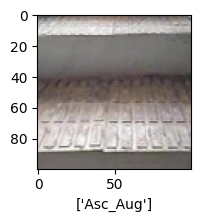

In [ ]:

def plot_sample(X, y, index):
    plt.figure(figsize=(2, 2))
    plt.imshow(X[index])
    plt.xlabel([y[index]])

plot_sample(Stair_Images,Stair_label,850)

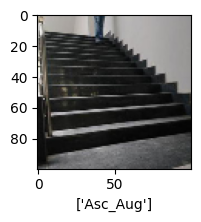

In [ ]:
def plot_sample(X, y, index):
    plt.figure(figsize=(2, 2))
    plt.imshow(X[index])
    plt.xlabel([y[index]])

plot_sample(Stair_Images,Stair_label,4)

TRAIN TEST SPLIT

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split (Stair_Images,Stair_label,train_size=0.7,random_state=64,shuffle=True)

In [ ]:
print("Shape of x_train:{}".format(x_train.shape))
print("Shape of y_train:{}".format(y_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train:(5250, 100, 100, 3)
Shape of y_train:(5250,)
Shape of x_test: (2250, 100, 100, 3)
Shape of y_test: (2250,)


NORMALIZATION OF PIXELS

In [12]:
#variable assigne
X_train = x_train/255
X_test  = x_test/255
Y_train = y_train
Y_test  = y_test

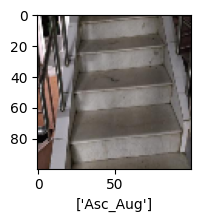

In [ ]:
def plot_sample(X, y, index):
    plt.figure(figsize=(2, 2))
    plt.imshow(X[index])
    plt.xlabel([y[index]])

plot_sample(X_train, Y_train,11)

LABEL ENCODING

In [13]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Encode y label/ dependent column
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.transform(Y_test)

for i in range(0,2):
    print("Class Label: {0}, --> Stair_type: {1}".format(i,le.inverse_transform([i])))

Class Label: 0, --> Stair_type: ['Asc_Aug']
Class Label: 1, --> Stair_type: ['Desc_Aug']


MOBILENET MODEL CREATION

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, BatchNormalization, Flatten

mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(100,100,3))
model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(64, activation = "ReLU"),
                    BatchNormalization(),
                    #Dropout(0.05),
                    Dense(32, activation = "ReLU"),
                    #Dropout(0.1),

                    #Dense(2, activation = "ReLU"),
                    #Dropout(0.01),
                    Dense(1, activation = "sigmoid")])

model.layers[0].trainable = False

model.compile(loss="binary_crossentropy", optimizer='adam', metrics="acc")

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                2080

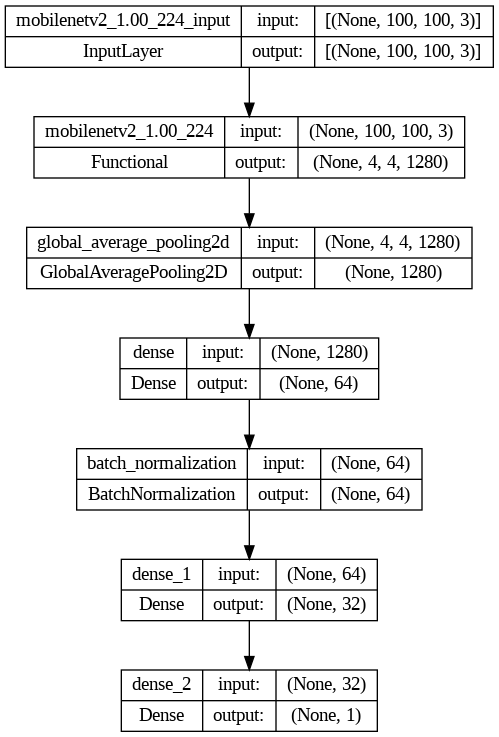

In [15]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/Staircase Dataset/check_points-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
   checkpoint_path, verbose=1, save_weights_only=True,
   # Save weights, every epoch.
   save_freq='epoch')

In [16]:
print(X_test.shape)
print(Y_test.shape)

(2250, 100, 100, 3)
(2250,)


MODEL TRAINING

In [17]:
interation=25
 #20,50
history = model.fit(X_train,Y_train,batch_size=8, epochs =interation, validation_data =(X_test, Y_test),verbose=1)#16,

Epoch 1/25
657/657 [==============================] - 63s 89ms/step - loss: 0.1359 - acc: 0.9522 - val_loss: 0.0396 - val_acc: 0.9876
Epoch 2/25
657/657 [==============================] - 42s 64ms/step - loss: 0.0558 - acc: 0.9819 - val_loss: 0.0125 - val_acc: 0.9969
Epoch 3/25
657/657 [==============================] - 49s 75ms/step - loss: 0.0240 - acc: 0.9926 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 4/25
657/657 [==============================] - 39s 59ms/step - loss: 0.0150 - acc: 0.9968 - val_loss: 5.7634e-04 - val_acc: 1.0000
Epoch 5/25
657/657 [==============================] - 39s 59ms/step - loss: 0.0113 - acc: 0.9966 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 6/25
657/657 [==============================] - 48s 73ms/step - loss: 0.0092 - acc: 0.9971 - val_loss: 9.4362e-04 - val_acc: 1.0000
Epoch 7/25
657/657 [==============================] - 38s 58ms/step - loss: 0.0139 - acc: 0.9952 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 8/25
657/657 [==============================] - 

In [ ]:
# Save the model as a SavedModel
model.save("my_model_mn_cnn.hdf5")

In [ ]:
# save in the H5 format
model.save("/content/drive/MyDrive/Colab Notebooks/Staircase Dataset/my_model_mn_cnn.hdf5")

In [ ]:
from keras.models import load_model

# load model
model = load_model('my_model_mn_cnn.hdf5')

MODEL TESTING AND RESULT

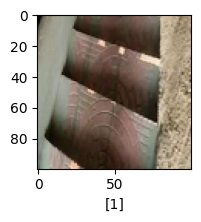

In [18]:
def plot_sample(X, y, index):
    plt.figure(figsize=(2, 2))
    plt.imshow(X[index])
    plt.xlabel([y[index]])

plot_sample(X_test, Y_test,100)

In [19]:
image=X_test[100]

In [ ]:
image.shape

(100, 100, 3)

In [20]:
img = image.reshape(1,100,100,3)

In [ ]:
img.shape

(1, 100, 100, 3)

1/1 [==============================] - 1s 596ms/step
[[0.99999696]]
The Face is : Descending


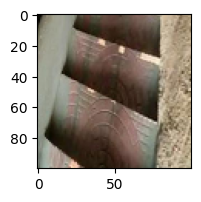

In [21]:
# make a prediction
ynew = model.predict(img)
print(ynew)

def plot_sample(X, y):

    plt.figure(figsize=(2, 2))
    plt.imshow(X[0])

plot_sample(img,ynew)

if(ynew>0.5):
  print("The Face is : Descending")
if(ynew<0.5):
  print("The Face is: Ascending")

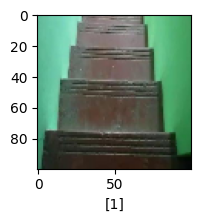

In [22]:
def plot_sample(X, y, index):
    plt.figure(figsize=(2, 2))
    plt.imshow(X[index])
    plt.xlabel([y[index]])

plot_sample(X_test, Y_test,150)

In [23]:
image=X_test[150]
img = image.reshape(1,100,100,3)

1/1 [==============================] - 0s 25ms/step
[[1.]]
The Face is : Descending


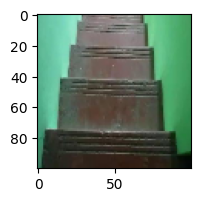

In [24]:
# make a prediction
ynew = model.predict(img)
print(ynew)

def plot_sample(X, y):

    plt.figure(figsize=(2, 2))
    plt.imshow(X[0])

plot_sample(img,ynew)

if(ynew>0.5):
  print("The Face is : Descending")
if(ynew<0.5):
  print("The Face is: Ascending")

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn import metrics

In [ ]:
X_test.shape

(2250, 100, 100, 3)

In [ ]:
y_pred_array=[]
for i in range (0,2250):
  image=X_test[i]
  img=image.reshape(1,100,100,3)
  ynew = model.predict(img)
  if(ynew>0.5):
    y_pred_array.append(1)
  if(ynew<0.5):
    y_pred_array.append(0)

1/1 [==============================] - 0s 63ms/step


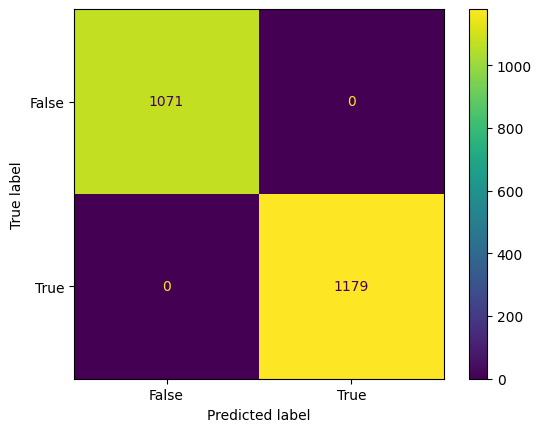

In [ ]:
confusion_matrix = metrics.confusion_matrix(Y_test, y_pred_array)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:

target_names = ['Ascending', 'Descending']
print(classification_report(Y_test,y_pred_array, target_names=target_names))

              precision    recall  f1-score   support

   Ascending       1.00      1.00      1.00      1071
  Descending       1.00      1.00      1.00      1179

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250



In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Set parameters for plotting
plt.rc('figure', figsize=(8, 4))
sns.set(font_scale=1)

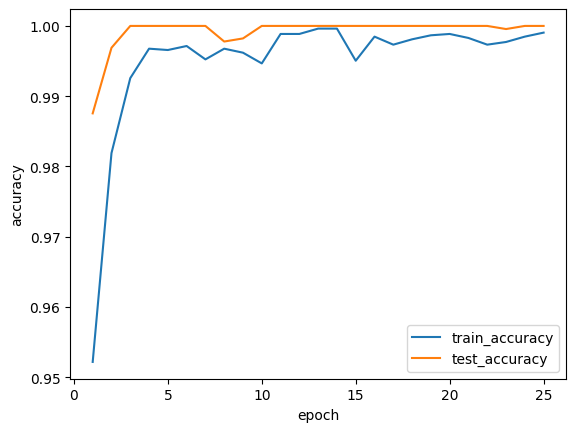

In [25]:
epochs=25
train_acc = history.history['acc']
val_acc = history.history['val_acc']

epochs_list = list(range(1, epochs + 1))

plt.plot(epochs_list, train_acc, label='train_accuracy')
plt.plot(epochs_list, val_acc, label='test_accuracy')
plt.title("")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')

In [ ]:
for key in model.history.history.keys():
    print(key)

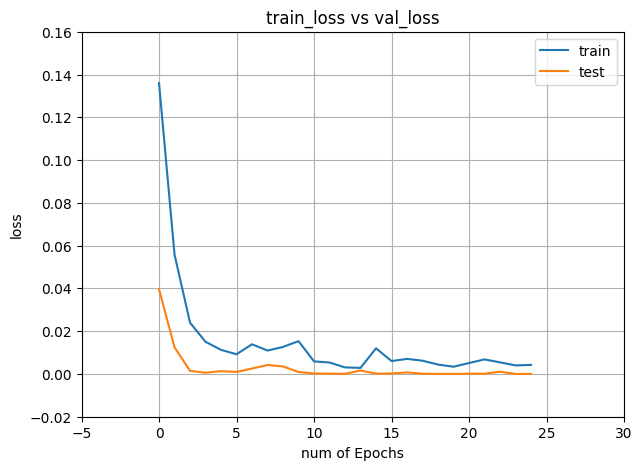

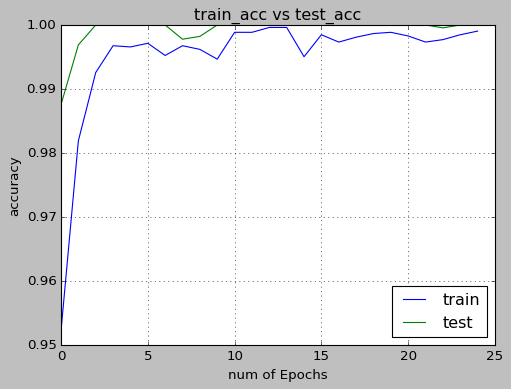

In [26]:
#Code by 'Real vs Fake face detection' https://www.kaggle.com/code/debasisdotcom/real-vs-fake-face-detection

epochs = 25
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_acc = history.history['acc']
test_acc = history.history['val_acc']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,test_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','test'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,test_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs test_acc')
plt.grid(True)
plt.legend(['train','test'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])